---

title: **Interpolation Comparison** (*v 1.0*)

**Methods**:

- 1. [Shape-based interpolation](https://www.researchgate.net/publication/221400411_Efficient_Semiautomatic_Segmentation_of_3D_Objects_in_Medical_Images) inspired by Schenk *et al*.

- 2. [*Pyspatiotemporalgeom*](https://dl.acm.org/doi/10.1145/2996913.2996973) library based interpolation 

- 3. Conditional CNN-VAE interpolation

---

In [17]:
from watermark import watermark
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, current_time=True, python=True, updated=True,
                iversions=True,  globals_= globals()))

Author: Tiago F. R. Ribeiro

Github username: Tiago1Ribeiro

Last updated: 2023-04-05 18:21:48

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

geopandas : 0.12.2
PIL       : 9.4.0
matplotlib: 3.7.1
shapely   : 2.0.1
cv2       : 4.7.0
numpy     : 1.24.2



In [18]:
### Notes...
### Metrics to compare interpolations
# - a) Root Mean Squared Error (RMSE)
# - b) Mean Absolute Error (MAE)
# - c) Mean Intersection over Union (MIoU)
# - d) Mean Hausdorff distance
# - e) IMPROVE TEMPORAL CONSISTENCY

### Libraries

In [31]:
import os   
import cv2                                          
import numpy as np                                                  
import math                                         
from glob import glob                              
from PIL import Image                              
import matplotlib.pyplot as plt             
from shapely import wkt              
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.affinity import scale
from rasterio.features import shapes  
from rasterio import Affine           
from shapely.wkt import loads
from shapely import hausdorff_distance
from shapely.validation import make_valid
import geopandas as gpd

### Data sources

In [20]:
DIR = os.getcwd()
# Reference U-Net Based Segmentations
UNET_DIR = os.path.join("E:\BurnedAreaUAV_files\Results")
UNET_PNG_DIR = os.path.join(UNET_DIR, "segs_base")
UNET_WKT_FILE = os.path.join(UNET_DIR, "WKT_files\segs_unet_base.wkt")
# Test Segmentation from BurnedAreaUAV dataset
BA_UAV_DIR = os.path.normpath("E://BurnedAreaUAV_files//BurnedAreaUAV_dataset")
BA_UAV_WKT = os.path.join(BA_UAV_DIR, "WKT_files//test.wkt")
# Interpolation Directory
INTERPOL_DIR = os.path.normpath("E://BurnedAreaUAV_files//Interpolation")
# Sampled Masks
SAMPLED_MASKS = os.path.join(INTERPOL_DIR, "reference_masks//sampled_masks.txt")
# Shape Based Interpolations
SHP_DIR = os.path.join(INTERPOL_DIR, "shape_interpol")
SHP_PNG_DIR = os.path.join(SHP_DIR, "PNGs")
SHP_PNG_DIR_SAMPLED = os.path.join(SHP_DIR, "PNGs_sampled")
SHP_WKT_FILE = os.path.join(SHP_DIR, "shape_interpol.wkt")
SHP_WKT_FILE_SAMPLED = os.path.join(SHP_DIR, "shape_interpol_sampled.wkt")
# Pyspatiotemporalgeom interpolations
PSTG_DIR = os.path.join(INTERPOL_DIR, "pyspatiotemporalgeom_interpol")
PSTG_PNG_DIR = os.path.join(PSTG_DIR, "PNGs")
PSTG_PNG_DIR_SAMPLED = os.path.join(PSTG_DIR, "PNGs_sampled")
PSTG_WKT_FILE = os.path.join(PSTG_DIR, "pyspatial_interpol.wkt")
PSTG_WKT_FILE_SAMPLED = os.path.join(PSTG_DIR, "pyspatial_interpol_sampled.wkt")
# Convolutional VAE interpolations (DESATUALIZADO)
CVAE_DIR = os.path.join(INTERPOL_DIR, "cvae_interpol")
CVAE_PNG_DIR = os.path.join(CVAE_DIR, "PNGs")
CVAE_PNG_DIR_SAMPLED = os.path.join(CVAE_DIR, "PNGs_sampled")
CVAE_WKT_FILE = os.path.join(CVAE_DIR, "cvae_interpol.wkt")
CVAE_WKT_FILE_SAMPLED = os.path.join(CVAE_DIR, "cvae_interpol_sampled.wkt")

In [21]:
# extract indexes from SAMPLED_MASKS file
idx_sampled = []
with open(SAMPLED_MASKS, 'r') as f:
    for line in f:
        # for each line, extract number before the comma
        idx_sampled.append(int(line.split(',')[0]))
# multiply every element of idx_sampled by 100
idx_sampled = [i*100 for i in idx_sampled]
print("Sampled indexes: ", idx_sampled)

Sampled indexes:  [0, 1900, 2800, 4800, 5600, 7400, 8200, 8700, 10600, 12800, 17300, 19500, 22500]


### Configs

In [22]:
IMG_ORIG_DIMS = (720, 1280)
# default number of polygons
NUM_POLYGONS = 22500

### Auxiliary functions

rmse

In [23]:
def rmse(wkt_true, wkt_pred):
    """
    Calcula o Root Mean Squared Error (RMSE) entre dois polígonos de segmentação
    no formato WKT.
    
    """
    poly_true = shapely.wkt.loads(wkt_true)
    poly_pred = shapely.wkt.loads(wkt_pred)

    # Extrai as coordenadas x e y dos vértices dos polígonos
    x_true, y_true = poly_true.exterior.coords.xy
    x_pred, y_pred = poly_pred.exterior.coords.xy

    # Calcula as diferenças quadráticas entre as coordenadas x e y 
    # dos vértices dos polígonos
    diff_x = np.subtract(x_true, x_pred)
    diff_y = np.subtract(y_true, y_pred)
    squared_diff_x = np.square(diff_x)
    squared_diff_y = np.square(diff_y)

    # Calcula a raiz quadrada da média das diferenças quadráticas
    mean_squared_diff = np.mean(squared_diff_x) + np.mean(squared_diff_y)
    rmse = math.sqrt(mean_squared_diff)

    return rmse

In [24]:
def make_valid(ob):
    """
    Validates a polygon and returns a valid polygon.
    """
    
    from shapely.geometry.base import geom_factory
    from shapely.geos import lgeos
    
    if ob.is_valid:
        return ob

    return geom_factory(lgeos.GEOSMakeValid(ob._geom))

iou_wkt

In [32]:
def iou_wkt(ground_truth_file, model_file, num_polygons=NUM_POLYGONS, discard_100=False):
    """
    Calculates the Intersection over Union (IoU) between segmentation polygons
    in WKT format.

    Parameters
    ----------
    ground_truth_file : str
        Path to the ground truth WKT file.
    model_file : str
        Path to the model WKT file.
    num_polygons : int, optional
        Number of polygons to be used in the calculation.
    
    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]
    g_t_polys = ground_truth_polys[:num_polygons]
    model_polys = model_polys[:num_polygons]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    iou_list = list()
    print("Calculating IoU...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        intersection = g_t_polys[i].intersection(model_polys[i]).area
        union = g_t_polys[i].union(model_polys[i]).area
        # Calculate the IoU
        iou = intersection / union
        iou_list.append(iou)    

    # Calculate the mean IoU
    iou_mean = sum(iou_list) / len(iou_list)

    return iou_mean, iou_list

temporal_consistency v1

In [26]:
def temporal_consistency(wkt_file, num_polygons):
    """
    Calculates the temporal consistency between segmentation polygons in 
    WKT format.

    Parameters
    ----------
    wkt_file : str
        Path to the WKT file.
    num_polygons : int
        Number of polygons to be used in the calculation.
        
    Returns
    -------
    t_c_mean : float
        Mean temporal consistency.
    t_c_list : list
        List of temporal consistency values.    
    """

    print("Reading WKTs file...")
    with open(wkt_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    model_polys = [loads(wkt) for wkt in model_wkt]
    model_polys = model_polys[:num_polygons]

    t_c_list = list()
    print("Calculating the temporal consistency...")
    for i in range(len(g_t_polys)-1):
        model_polys[i] = make_valid(model_polys[i])
        model_polys[i+1] = make_valid(model_polys[i+1])
        # calculates the temporal consistency between two consecutive polygons
        t_c = model_polys[i].difference(model_polys[i+1]).area / g_t_polys[i+1].area
        t_c_list.append(t_c)
    
    # Calcula a média 
    t_c_mean = sum(t_c_list) / len(t_c_list)

    return t_c_mean, t_c_list

strided_temporal_consistency

In [27]:
def strided_temporal_consistency(model_polys, num_polygons, stride=1, exp = True):
    """
    Calculates the temporal consistency between consecutive polygons in a sequence.

    Args:
        model_polys (list): A list of Shapely Polygon objects representing the 
                            sequence of polygons.
        num_polygons (int): The total number of polygons in the sequence.
        stride (int, optional): The number of polygons to skip between 
                                comparisons. Defaults to 1.

    Returns:
        dict: A dictionary containing the temporal consistency values and 
              related information. The keys are:
            - i (list): A list of the starting indices of the compared polygon pairs.
            - strd (int): The stride value used.
            - tc (list): A list of the temporal consistency values calculated 
                         for each pair of polygons.
            - tc_mean (float): The mean temporal consistency value.
    """

    # Create empty dictionary to store the TC values and and indexes
    t_c = {key: [] for key in ["i", "strd", "tc", "tc_mean"]}

    # Make all polygons in the list valid before calculating temporal consistency
    model_polys = [make_valid(poly) for poly in model_polys]

    print(f"Calculating the temporal consistency with stride {stride}...")
    for i in range(0, num_polygons - stride, stride):
        # Calculates the temporal consistency between two consecutive polygons
        t_c["i"].append(i)
        tc_temp = (model_polys[i].difference(model_polys[i+stride]).area / model_polys[i+stride].area)
        if exp: 
            t_c["tc"].append(np.exp(-10*tc_temp))
        else:
            t_c["tc"].append(tc_temp)
        
    # Calculates the mean of the temporal consistency
    t_c["tc_mean"] = sum(t_c["tc"]) / len(t_c["tc"])
    t_c["strd"] = stride

    return t_c

Scaled Temporal Consistency plot

C:\Users\tiago\AppData\Local\Temp\ipykernel_8668\596977383.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


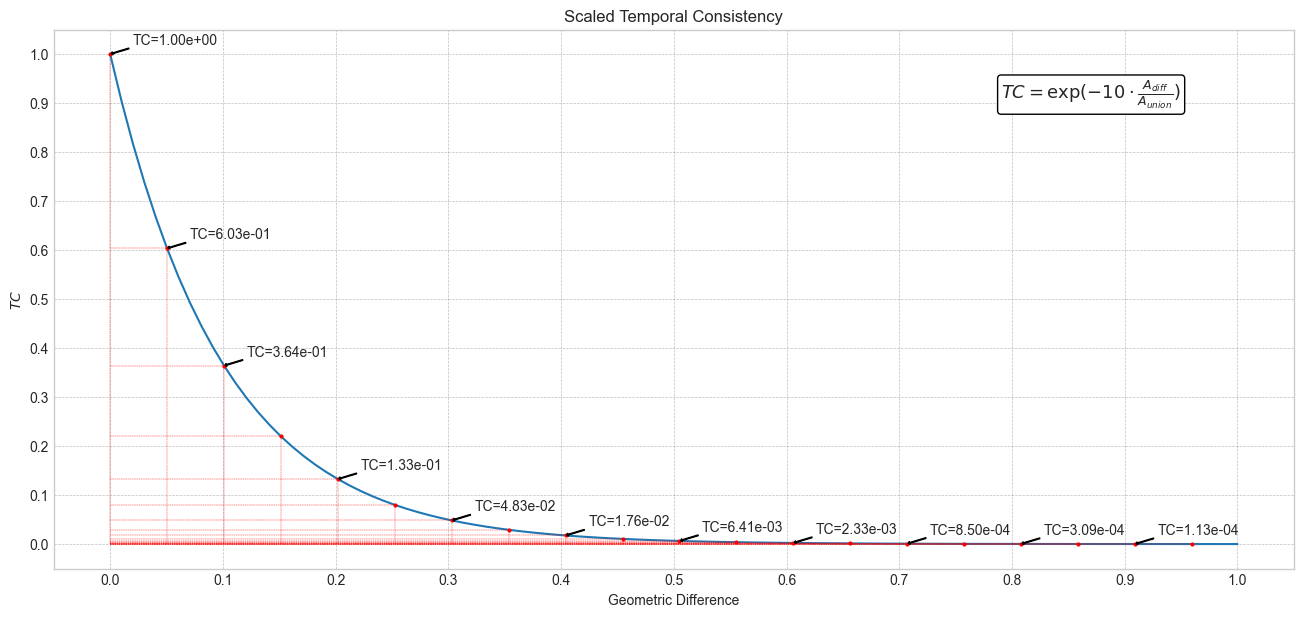

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# figure size
plt.rcParams['figure.figsize'] = [16, 7]
plt.style.use('seaborn-whitegrid')


# Sample geometric differece values
# => worst case scenario: 1 (no overlap)
# => best case scenario: 0  (perfect overlap)
geom_diff = np.linspace(0, 1, 100)

# Compute logarithmic scaling
def scale(x):
    return np.exp(-10*x)

# Plot
fig, ax = plt.subplots()
ax.plot(geom_diff, scale(geom_diff))
ax.set_xlabel('Geometric Difference')
ax.set_ylabel('$TC$')
ax.set_title('Scaled Temporal Consistency')
# grid dashed line
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

# xticks
ax.set_xticks(np.arange(0, 1.1, 0.1))
# yticks
ax.set_yticks(np.arange(0, 1.1, 0.1))

# add labels and points for a few points
for i in range(0, 100, 5):
    ax.plot(geom_diff[i], scale(geom_diff[i]), 'ro', markersize=2)
    # add a line from the point to the x-axis
    ax.plot([geom_diff[i], geom_diff[i]], [0, scale(geom_diff[i])], 'r--', linewidth=0.3)
    # add a line from the point to the y-axis
    ax.plot([0, geom_diff[i]], [scale(geom_diff[i]), scale(geom_diff[i])], 'r--', linewidth=0.3)
    # add labels with small arrow for the first 8 point and then every 2th point 
    if i < 8 or i % 2 == 0:
        ax.annotate(f'TC={scale(geom_diff[i]):.2e}', 
                    xy=(geom_diff[i], scale(geom_diff[i])), 
                    xytext=(geom_diff[i]+0.02, scale(geom_diff[i])+0.02), 
                    arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=2, headlength=1))
                                     

# add box, white background with the complete TC formula, including the math symbols and the exponent, LateX style, top right 
ax.text(0.95, 0.95, r'$TC = \exp(-10 \cdot \frac{A_{diff}}{A_{union}})$', 
       fontsize=13, horizontalalignment='right', verticalalignment='top', 
       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
plt.show()

hausdorff_dist_wkt

In [51]:
def hausdorff_dist_wkt(ground_truth_file, model_file, last_frame=22500, discard_100=False):
    """
    Calculates the Hausdorff distance between the ground truth and the model.

    Args:
        ground_truth_file (str): The path to the ground truth WKTS file.
        model_file (str): The path to the model WKTS file.
        last_frame (int, optional): The last frame to consider. Defaults to 22500.
        discard (bool, optional): Whether to discard polygons which index number 
        is multiple of 100 (0, 100, 200, 300, etc). Defaults to False.  

    Returns:
        dict: A dictionary containing the Hausdorff distance values and related 
        information. The keys are:
            - i (list): A list of the starting indices of the compared polygon
             pairs.
            - hd (list): A list of the Hausdorff distance values calculated for 
            each pair of polygons.
            - hd_mean (float): The mean Hausdorff distance value.

    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]

    g_t_polys = ground_truth_polys[:last_frame]
    model_polys = model_polys[:last_frame]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    hausdorff_dist_list = list()
    print("Calculating Hausdorf Distance...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        # hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(loads(model_polys[i]))
        hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
        hausdorff_dist_list.append(hausdorff_dist)    

    # Calcula a média dos valores de IoU
    hausdorff_dist_mean = sum(hausdorff_dist_list) / len(hausdorff_dist_list)

    return hausdorff_dist_mean, hausdorff_dist_list

# 0.25 Hz Interpolations

## Comparison with **UNET** generated segmentations

### IoU metric

In [33]:
%%time
iou_shp, iou_list_shp = iou_wkt(UNET_WKT_FILE, SHP_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
print(f"Shape based interpolation: meanIou {iou_shp:.3f} \n")
iou_cvae, iou_list_cvae = iou_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
print(f"Conditional VAE interpolation: meanIoU {iou_cvae:.3f} \n")
iou_pstg, iou_list_pstg = iou_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
print(f"Pyspatiotemporalgeom interpolation: meanIoU {iou_pstg:.3f} \n")

Reading WKTs files...
Calculating IoU...
Shape based interpolation: meanIou 0.744 

Reading WKTs files...
Calculating IoU...
Conditional VAE interpolation: meanIoU 0.739 

Reading WKTs files...
Calculating IoU...
Pyspatiotemporalgeom interpolation: meanIoU 0.703 

CPU times: total: 4min
Wall time: 4min


### Boxplots for the IoU 

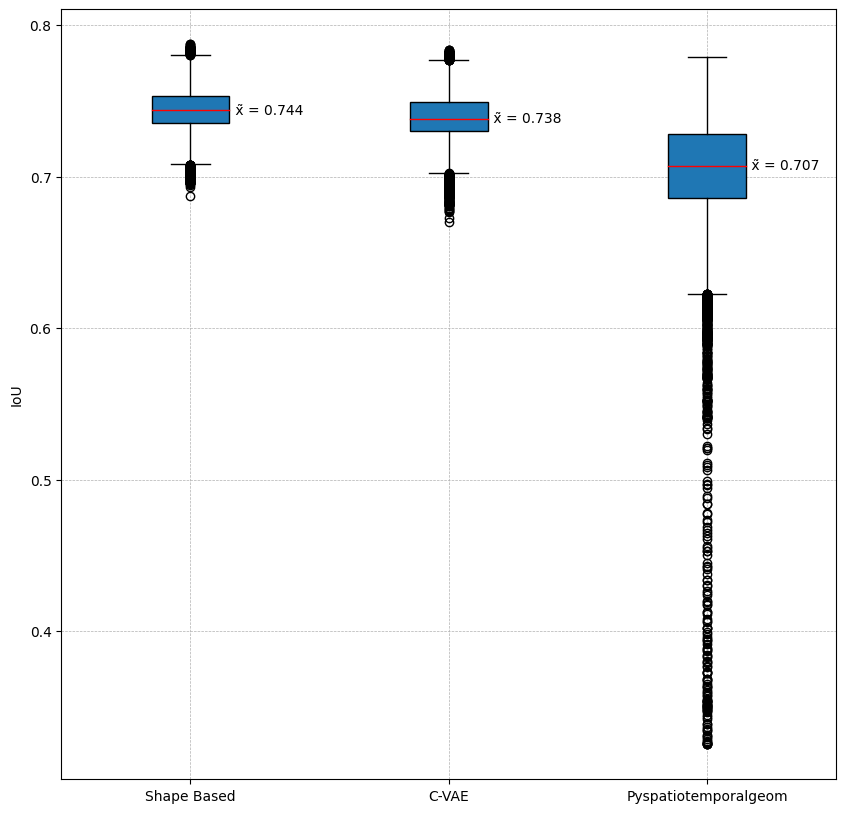

(None,)

In [46]:
# Combine the data into a list
data = [iou_list_shp, iou_list_cvae, iou_list_pstg]

fig, ax = plt.subplots(figsize=(10, 10))

boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'}, 
                     patch_artist=True)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.3f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('IoU')

# Show the plot
plt.show();

### Hausdorf Distance

In [52]:
%%time
hd_shp, hd_list_shp = hausdorff_dist_wkt(UNET_WKT_FILE, SHP_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_shp:.3f} \n")
hd_cvae, hd_list_cvae = hausdorff_dist_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_cvae:.3f} \n")
hd_pstg, hd_list_pstg = hausdorff_dist_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_pstg:.3f} \n")

Reading WKTs files...
Calculating Hausdorf Distance...


### Boxplots for Hausdord Distance

In [ ]:
# Combine the data into a list
data = [hd_list_shp, hd_list_cvae, hd_list_pstg]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the boxplot with median annotation
boxplot = ax.boxplot(data, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], 
                     medianprops={'linewidth': 1, 'color': 'red'}, 
                     patch_artist=False)

# Add dashed gridlines
ax.grid(linestyle='--', linewidth=0.5)

# # Add annotation for median values
for i, box in enumerate(boxplot['medians']):
    ax.annotate(f" x͂ = {box.get_ydata()[0]:.1f}", 
                xy=(i+1, box.get_ydata()[0]), 
                xytext=(29, 0),
                textcoords='offset points',
                va='center')
ax.set_ylabel('Hausdorf Distance')

# Show the plot
plt.show()

NameError: name 'hd_list_shp' is not defined

## Comparison with the BurnedAreaUAV **Test set**

### Data preparation

In [147]:
# test set frame indexes 
idx = np.linspace(20250, 22450, 23).astype(int)  

# Read WKTS files
print("Reading WKTs files...")
with open(BA_UAV_WKT, "r") as f:
    test_wkt = f.read().splitlines()

with open(SHP_WKT_FILE, "r") as f:
    shp_wkt = f.read().splitlines()

with open(CVAE_WKT_FILE, "r") as f:
    cvae_wkt = f.read().splitlines()

with open(PSTG_WKT_FILE, "r") as f:
    pstg_wkt = f.read().splitlines()

print("Filtering WKTs files...")
shp_wkt = [shp_wkt[i] for i in idx]
cvae_wkt = [cvae_wkt[i] for i in idx]
pstg_wkt = [pstg_wkt[i] for i in idx]
# print the length of all wkt files
print(f"Shape based interpolation: {len(shp_wkt)} frames")
print(f"Conditional VAE interpolation: {len(cvae_wkt)} frames")
print(f"Pyspatiotemporalgeom interpolation: {len(pstg_wkt)} frames ")
print(f"Test set: {len(test_wkt)} frames")


Reading WKTs files...
Filtering WKTs files...
Shape based interpolation: 23 frames
Conditional VAE interpolation: 23 frames
Pyspatiotemporalgeom interpolation: 23 frames 
Test frames: 23 frames


#### Hausdorf Distance 

In [183]:
# converts Test set ground truth polygon to shapely format
g_t_polys = [loads(wkt) for wkt in test_wkt]

# polygons generated by the shape based interpolation 
model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(model_polys[i])
    hd_list_shp.append(hausdorff_dist)    

hd_mean_shp = sum(hd_list_shp) / len(hd_list_shp)
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp:.3f} \n")

Calculating Hausdorf Distance...
Shape based interpolation: mean Hausdorf Dist. 712.696 



In [184]:
model_polys = [loads(wkt) for wkt in cvae_wkt]
hd_list_cvae = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(model_polys[i])
    hd_list_cvae.append(hausdorff_dist)    

hd_mean_cvae = sum(hd_list_cvae) / len(hd_list_cvae)
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_mean_cvae:.3f} \n")

Calculating Hausdorf Distance...
Conditional VAE interpolation: mean Hausdorf Dist. 714.868 



In [186]:
model_polys = [loads(wkt) for wkt in pstg_wkt]
hd_list_pstg = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(model_polys[i])
    hd_list_pstg.append(hausdorff_dist)    

hd_mean_pstg = sum(hd_list_pstg) / len(hd_list_pstg)
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_mean_pstg:.3f} \n")

Calculating Hausdorf Distance...
Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 713.120 



### IoU - Test Set

In [1]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_list_cvae = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_cvae.append(iou)
    
iou_mean_cvae = sum(iou_list_cvae) / len(iou_list_cvae)

NameError: name 'cvae_wkt' is not defined

In [ ]:
# Shape based
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_list_shp = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_shp.append(iou)

iou_mean_shp = sum(iou_list_shp) / len(iou_list_shp)

In [ ]:
# Pyspatiotemporalgeom
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_list_pstg = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_pstg.append(iou)

iou_mean_pstg = sum(iou_list_pstg) / len(iou_list_pstg)

In [ ]:
print(f"Conditional VAE interpolation: mean IoU {iou_mean_cvae:.3f} \n")
print(f"Shape based interpolation: mean IoU {iou_mean_shp:.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_mean_pstg:.3f} \n")

### Boxplots: IoU Test Set

In [ ]:
# IoU boxplots in one figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('IoU boxplots')
ax.boxplot([iou_list_shp, iou_list_cvae, iou_list_pstg], labels=['Shape based', 'Conditional VAE', 'Pyspatiotemporalgeom'])
plt.show()


## Temporal Consistency (0,25 Hz Interpolations)

### Exponetial Strided TC

In [361]:
# CVAE
print("Reading WKTs file...")
with open(CVAE_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_list = list()

stride_rng = 10
for str in range(1, stride_rng+1):
    t_c = temporal_consistency(polygons, num_polygons, stride = str)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Conditional VAE interpolation: mean TC 9.7593e-01 with stride 1 

Calculating the temporal consistency with stride 2...
Conditional VAE interpolation: mean TC 9.7618e-01 with stride 2 

Calculating the temporal consistency with stride 3...
Conditional VAE interpolation: mean TC 9.7630e-01 with stride 3 

Calculating the temporal consistency with stride 4...
Conditional VAE interpolation: mean TC 9.7652e-01 with stride 4 

Calculating the temporal consistency with stride 5...
Conditional VAE interpolation: mean TC 9.7691e-01 with stride 5 

Calculating the temporal consistency with stride 6...
Conditional VAE interpolation: mean TC 9.7702e-01 with stride 6 

Calculating the temporal consistency with stride 7...
Conditional VAE interpolation: mean TC 9.7709e-01 with stride 7 

Calculating the temporal consistency with stride 8...
Conditional VAE interpolation: mean TC 9.7753e-01 with stride 8 

Calculating the tem

In [362]:
# Shape based
print("Reading WKTs file...")
with open(SHP_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_shp_list = list()
stride_rng = 10
for str in range(1, stride_rng+1):
    t_c = temporal_consistency(polygons, num_polygons, stride = str)
    print(f"Shape based interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_shp_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Shape based interpolation: mean TC 9.9743e-01 with stride 1 

Calculating the temporal consistency with stride 2...
Shape based interpolation: mean TC 9.9488e-01 with stride 2 

Calculating the temporal consistency with stride 3...
Shape based interpolation: mean TC 9.9233e-01 with stride 3 

Calculating the temporal consistency with stride 4...
Shape based interpolation: mean TC 9.8979e-01 with stride 4 

Calculating the temporal consistency with stride 5...
Shape based interpolation: mean TC 9.8727e-01 with stride 5 

Calculating the temporal consistency with stride 6...
Shape based interpolation: mean TC 9.8475e-01 with stride 6 

Calculating the temporal consistency with stride 7...
Shape based interpolation: mean TC 9.8225e-01 with stride 7 

Calculating the temporal consistency with stride 8...
Shape based interpolation: mean TC 9.7976e-01 with stride 8 

Calculating the temporal consistency with stride 9.

In [363]:
# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open( PSTG_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_pstg_list = list()
stride_rng = 10
for str in range(1, stride_rng+1):
    t_c = temporal_consistency(polygons, num_polygons, stride = str)
    print(f"Pyspatiotemporalgeom interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_pstg_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...


c:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


Pyspatiotemporalgeom interpolation: mean TC 9.5377e-01 with stride 1 

Calculating the temporal consistency with stride 2...


c:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


Pyspatiotemporalgeom interpolation: mean TC 9.1460e-01 with stride 2 

Calculating the temporal consistency with stride 3...


c:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
c:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: divide by zero encountered in difference
  return lib.difference(a, b, **kwargs)


Pyspatiotemporalgeom interpolation: mean TC 8.8103e-01 with stride 3 

Calculating the temporal consistency with stride 4...
Pyspatiotemporalgeom interpolation: mean TC 8.5262e-01 with stride 4 

Calculating the temporal consistency with stride 5...
Pyspatiotemporalgeom interpolation: mean TC 8.2763e-01 with stride 5 

Calculating the temporal consistency with stride 6...
Pyspatiotemporalgeom interpolation: mean TC 8.0527e-01 with stride 6 

Calculating the temporal consistency with stride 7...
Pyspatiotemporalgeom interpolation: mean TC 7.8498e-01 with stride 7 

Calculating the temporal consistency with stride 8...
Pyspatiotemporalgeom interpolation: mean TC 7.6681e-01 with stride 8 

Calculating the temporal consistency with stride 9...
Pyspatiotemporalgeom interpolation: mean TC 7.4563e-01 with stride 9 

Calculating the temporal consistency with stride 10...
Pyspatiotemporalgeom interpolation: mean TC 7.3505e-01 with stride 10 



### Boxplots and tables: Exp. Strided TC

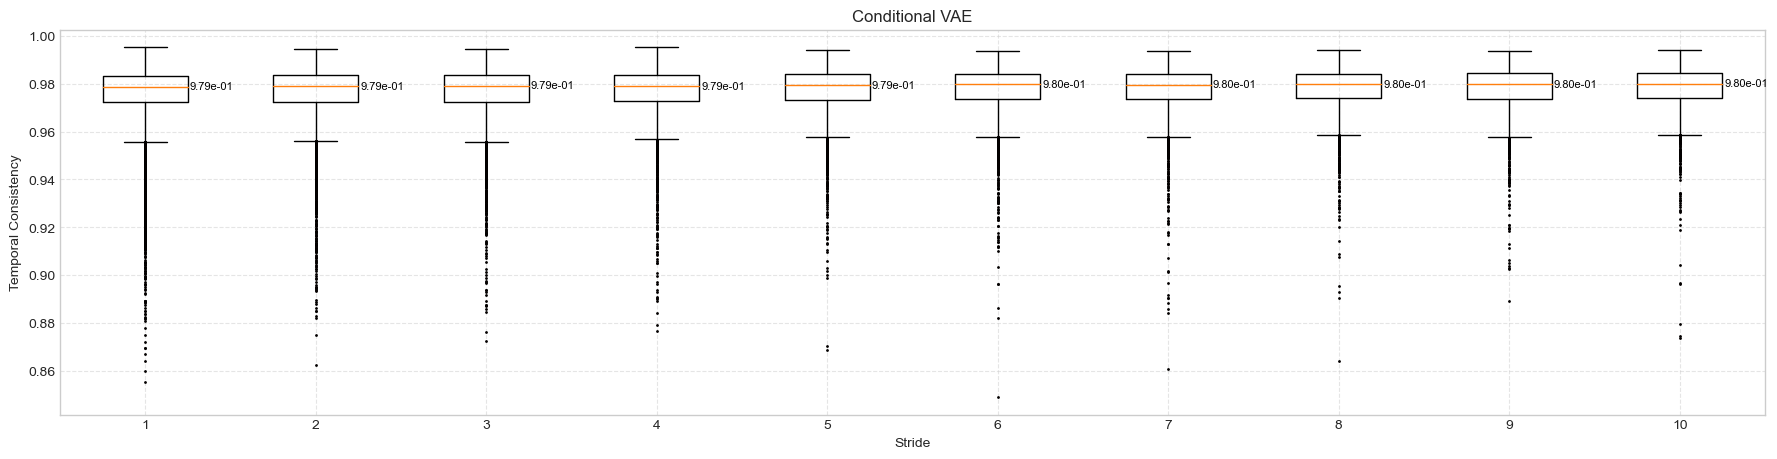

In [391]:
# CVAE boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))
# plots style
plt.style.use('seaborn-whitegrid')
ax.set_title('Conditional VAE')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers
ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)], 
           flierprops=dict(markerfacecolor='r', markersize=1))   

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
    

ax.grid( linestyle="--", alpha=0.5)
plt.show()

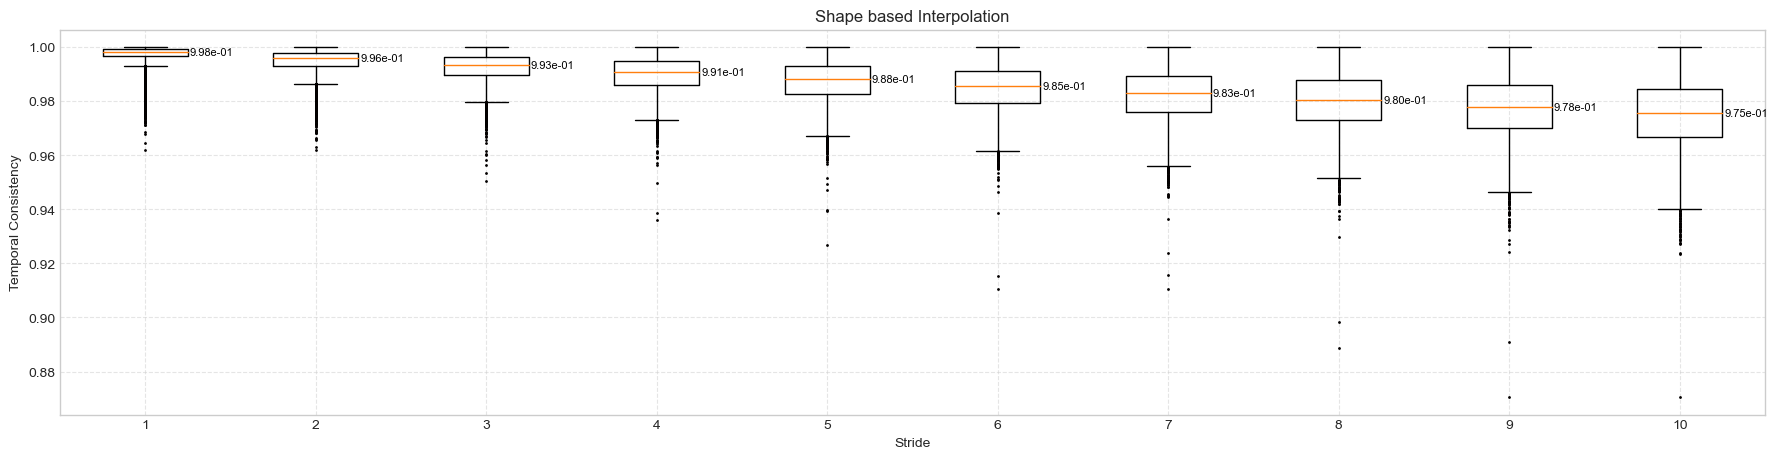

In [394]:
# Shape based boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))
# plots style
plt.style.use('seaborn-whitegrid')
ax.set_title('Shape based Interpolation')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers
ax.boxplot([tc_shp_list[i]["tc"] for i in range(0, stride_rng)],
              flierprops=dict(markerfacecolor='r', markersize=1))       

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_shp_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_shp_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')

ax.grid( linestyle="--", alpha=0.5)
plt.show()

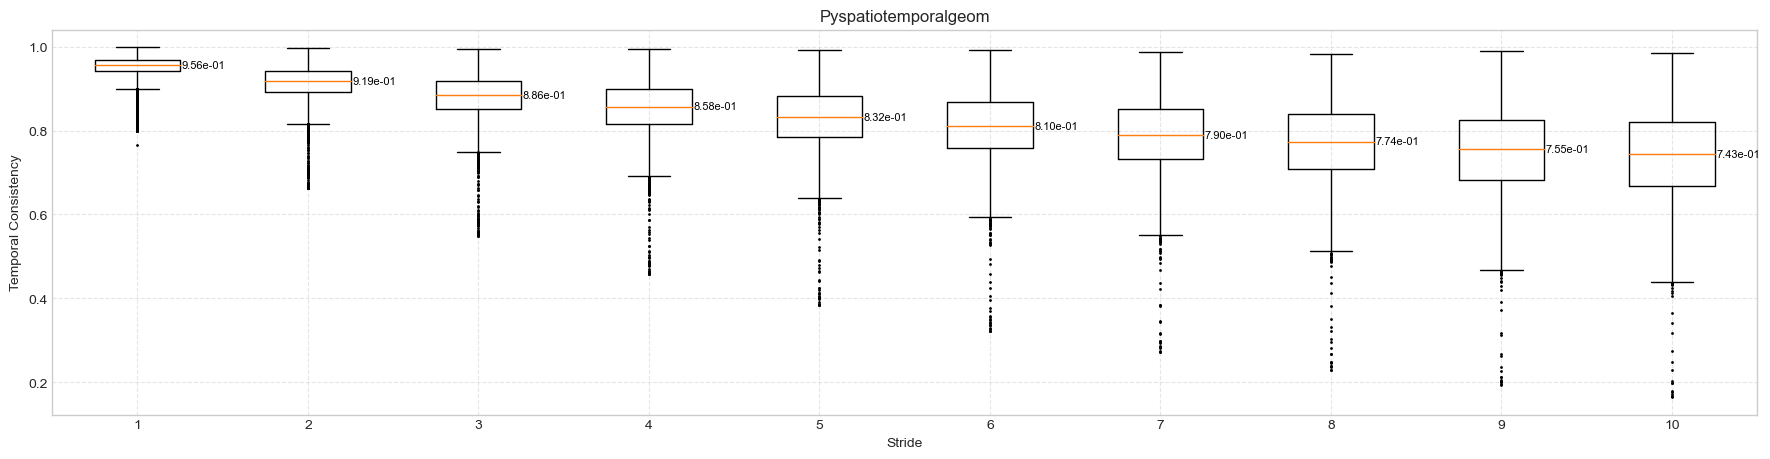

In [393]:
# Pyspatiotemporalgeom boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))
# plots style
plt.style.use('seaborn-whitegrid')
ax.set_title('Pyspatiotemporalgeom')
# boxplot with all the values
# ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
# smaller outliers
ax.boxplot([tc_pstg_list[i]["tc"] for i in range(0, stride_rng)],
                flierprops=dict(markerfacecolor='r', markersize=1))

ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_pstg_list[i]['tc']):.2e}", (i+1, 
                np.median(tc_pstg_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')
                
ax.grid( linestyle="--", alpha=0.5)
plt.show()


# Distance Sampled Interpolations

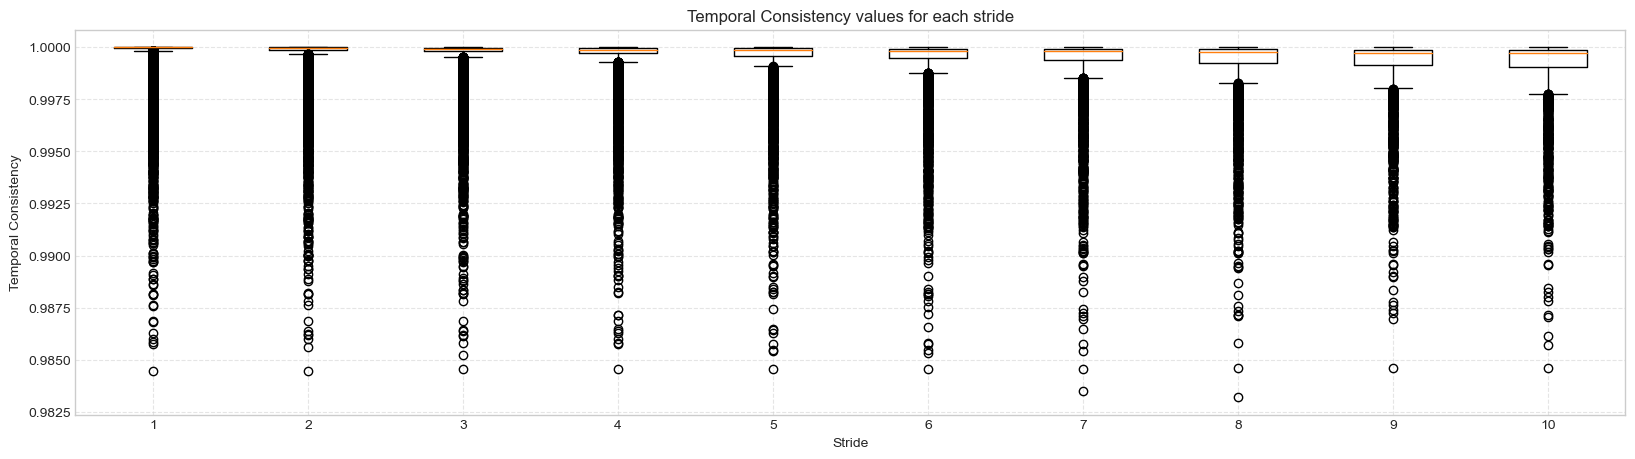

In [343]:
# boxplot with tc values for each stride on the same plot and a boxplot including all the values 
fig, ax = plt.subplots(figsize=(20, 5))
# plots style
plt.style.use('seaborn-whitegrid')
# boxplot with all the values
ax.boxplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
ax.set_title("Temporal Consistency values for each stride")
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

ax.grid( linestyle="--", alpha=0.5)
plt.show()

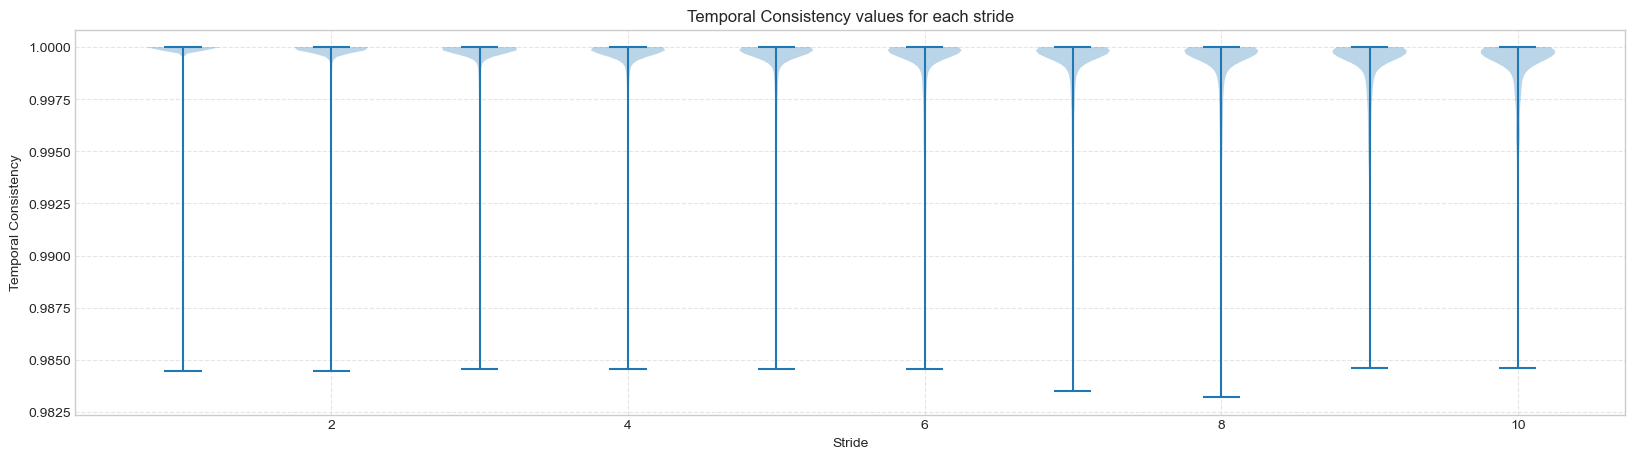

In [339]:
# Violin plot with tc values for each stride on the same plot and a boxplot including all the values
fig, ax = plt.subplots(figsize=(20, 5))
# plots style
plt.style.use('seaborn-whitegrid')
# boxplot with all the values
ax.violinplot([tc_list[i]["tc"] for i in range(0, stride_rng)])
ax.set_title("Temporal Consistency values for each stride")
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")
ax.grid( linestyle="--", alpha=0.5)
plt.show()


## Graph Based Evaluation (Work in Progress..)

In [ ]:
import networkx as nx
from shapely.geometry import Polygon
import numpy as np

def compute_graph_consistency(frames_polygons, frames_masks, threshold=0.5):
    """
    Compute temporal consistency between frames using a graph-based approach.
    
    Parameters:
        frames_polygons (list): List of Shapely polygons representing the burned area for each frame.
        frames_masks (list): List of binary masks representing the burned area for each frame.
        threshold (float): Threshold value for considering a pixel as burned or unburned.
        
    Returns:
        float: Temporal consistency score between 0 and 1.
    """
    # Define a function to compute the intersection over union (IoU) between two polygons
    def compute_iou(poly1, poly2):
        intersection = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        return intersection / union
    
    # Build a graph for each frame using the polygon centroids as nodes
    graphs = []
    for polygons in frames_polygons:
        graph = nx.Graph()
        centroids = [poly.centroid for poly in polygons]
        for i, centroid1 in enumerate(centroids):
            for j, centroid2 in enumerate(centroids):
                if i != j:
                    poly1 = polygons[i]
                    poly2 = polygons[j]
                    iou = compute_iou(poly1, poly2)
                    if iou > 0:
                        graph.add_edge(i, j, weight=iou)
        graphs.append(graph)
    
    # Compute the temporal consistency score
    scores = []
    for i in range(len(graphs)-1):
        graph1 = graphs[i]
        graph2 = graphs[i+1]
        intersection = 0
        union = 0
        for node in graph1.nodes:
            poly1 = frames_polygons[i][node]
            mask1 = frames_masks[i][:,:,0]
            mask1 = np.where(mask1 > threshold, 1, 0)
            for neighbor in graph1.neighbors(node):
                poly2 = frames_polygons[i][neighbor]
                mask2 = frames_masks[i][:,:,0]
                mask2 = np.where(mask2 > threshold, 1, 0)
                if graph2.has_edge(node, neighbor):
                    poly3 = frames_polygons[i+1][node]
                    mask3 = frames_masks[i+1][:,:,0]
                    mask3 = np.where(mask3 > threshold, 1, 0)
                    intersection += np.sum(np.logical_and(mask1, mask3)) + np.sum(np.logical_and(mask2, mask3))
                    union += np.sum(np.logical_or(mask1, mask2)) + np.sum(mask3)
        score = intersection / union if union > 0 else 1.0
        scores.append(score)
    
    # Return the average temporal consistency score
    return np.mean(scores)


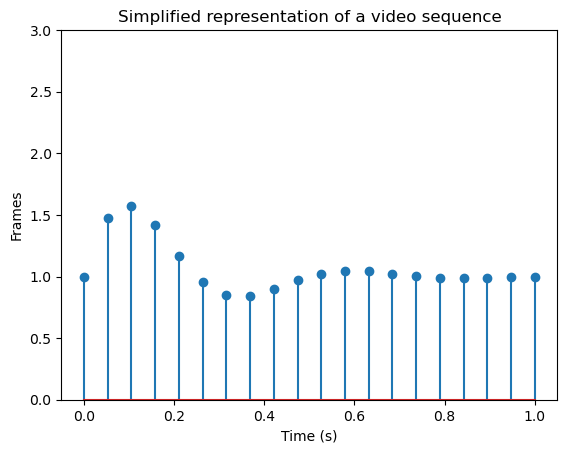

In [11]:
import numpy as np
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 20)
y = np.abs( np.sin(4 * np.pi * t) * np.exp(-5 * t) + 1)
# y limits
plt.ylim(0, 3)

plt.stem(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Frames')
# title
plt.title('Simplified representation of a video sequence')

plt.show()



In [ ]:
def compute_temporal_consistency(polygons, segmentations, window_size):
    """
    Computes the temporal consistency metric for a list of polygons and 
    corresponding segmentation images, using a rolling window approach with 
    the given window size.
    """
    num_frames = len(polygons)
    tc_values = []
    
    for i in range(num_frames - window_size + 1):
        # Get the polygons and segmentations for the current window
        window_polygons = polygons[i:i+window_size]
        window_segmentations = segmentations[i:i+window_size]
        
        # Compute the polygon overlap matrix for the current window
        overlap_matrix = compute_overlap_matrix(window_polygons)
        
        # Compute the temporal consistency for each pair of consecutive frames in the current window
        for j in range(window_size - 1):
            tc = compute_tc_between_frames(window_segmentations[j], window_segmentations[j+1], overlap_matrix[j], overlap_matrix[j+1])
            tc_values.append(tc)
    
    # Compute the average temporal consistency across all window positions
    avg_tc = sum(tc_values) / len(tc_values)
    
    return avg_tc

In [ ]:
import numpy as np
from shapely.geometry import Polygon

def compute_overlap_matrix(polygons1, polygons2):
    # Initialize overlap matrix
    overlap_matrix = np.zeros((len(polygons1), len(polygons2)), dtype=np.int32)
    
    # Compute pairwise intersection between polygons
    for i, poly1 in enumerate(polygons1):
        for j, poly2 in enumerate(polygons2):
            if poly1.intersects(poly2):
                overlap_matrix[i, j] = 1
                
    return overlap_matrix


In [167]:
model_polys = [loads(wkt) for wkt in cvae_wkt]
tc_cvae_list = list()
print("Calculating the temporal consistency...")
for i in range(len(g_t_polys)-1):
    model_polys[i] = make_valid(model_polys[i])
    model_polys[i+1] = make_valid(model_polys[i+1])
    t_c = model_polys[i].difference(model_polys[i+1]).area / g_t_polys[i+1].area
    tc_cvae_list.append(t_c)
    
# Calcula a média
tc_cvae_mean = sum(tc_cvae_list) / len(tc_cvae_list)
print(f"Conditional VAE interpolation: mean TC {tc_cvae_mean:.4e} \n")

Calculating the temporal consistency...
Conditional VAE interpolation: mean TC 1.7536e-03 



In [169]:
model_polys = [loads(wkt) for wkt in pstg_wkt]
tc_pstg_list = list()
print("Calculating the temporal consistency...")
for i in range(len(g_t_polys)-1):
    model_polys[i] = make_valid(model_polys[i])
    model_polys[i+1] = make_valid(model_polys[i+1])
    t_c = model_polys[i].difference(model_polys[i+1]).area / g_t_polys[i+1].area
    tc_pstg_list.append(t_c)

# Calcula a média
tc_pstg_mean = sum(tc_pstg_list) / len(tc_pstg_list)
print(f"Pyspatiotemporalgeom interpolation: mean TC {tc_pstg_mean:.4e} \n")

Calculating the temporal consistency...
Pyspatiotemporalgeom interpolation: mean TC 3.8945e-02 



#### IoU

In [170]:
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_shp_list = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    intersection = g_t_polys[i].intersection(model_polys[i]).area
    union = g_t_polys[i].union(model_polys[i]).area
    # Calculate the IoU
    iou = intersection / union
    iou_shp_list.append(iou)    

# Calcula a média dos valores de IoU
iou_shp_mean = sum(iou_shp_list) / len(iou_shp_list)
print(f"Shape based interpolation: mean IoU {iou_shp_mean:.3f} \n")

Calculating IoU...
Shape based interpolation: mean IoU 0.959 



In [171]:
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_cvae_list = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    intersection = g_t_polys[i].intersection(model_polys[i]).area
    union = g_t_polys[i].union(model_polys[i]).area
    # Calculate the IoU
    iou = intersection / union
    iou_cvae_list.append(iou)

# Calcula a média dos valores de IoU
iou_cvae_mean = sum(iou_cvae_list) / len(iou_cvae_list)
print(f"Conditional VAE interpolation: mean IoU {iou_cvae_mean:.3f} \n")

Calculating IoU...
Conditional VAE interpolation: mean IoU 0.949 



In [172]:
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_pstg_list = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    intersection = g_t_polys[i].intersection(model_polys[i]).area
    union = g_t_polys[i].union(model_polys[i]).area
    # Calculate the IoU
    iou = intersection / union
    iou_pstg_list.append(iou)

# Calcula a média dos valores de IoU
iou_pstg_mean = sum(iou_pstg_list) / len(iou_pstg_list)
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_pstg_mean:.3f} \n")

Calculating IoU...
Pyspatiotemporalgeom interpolation: mean IoU 0.822 



#### plots

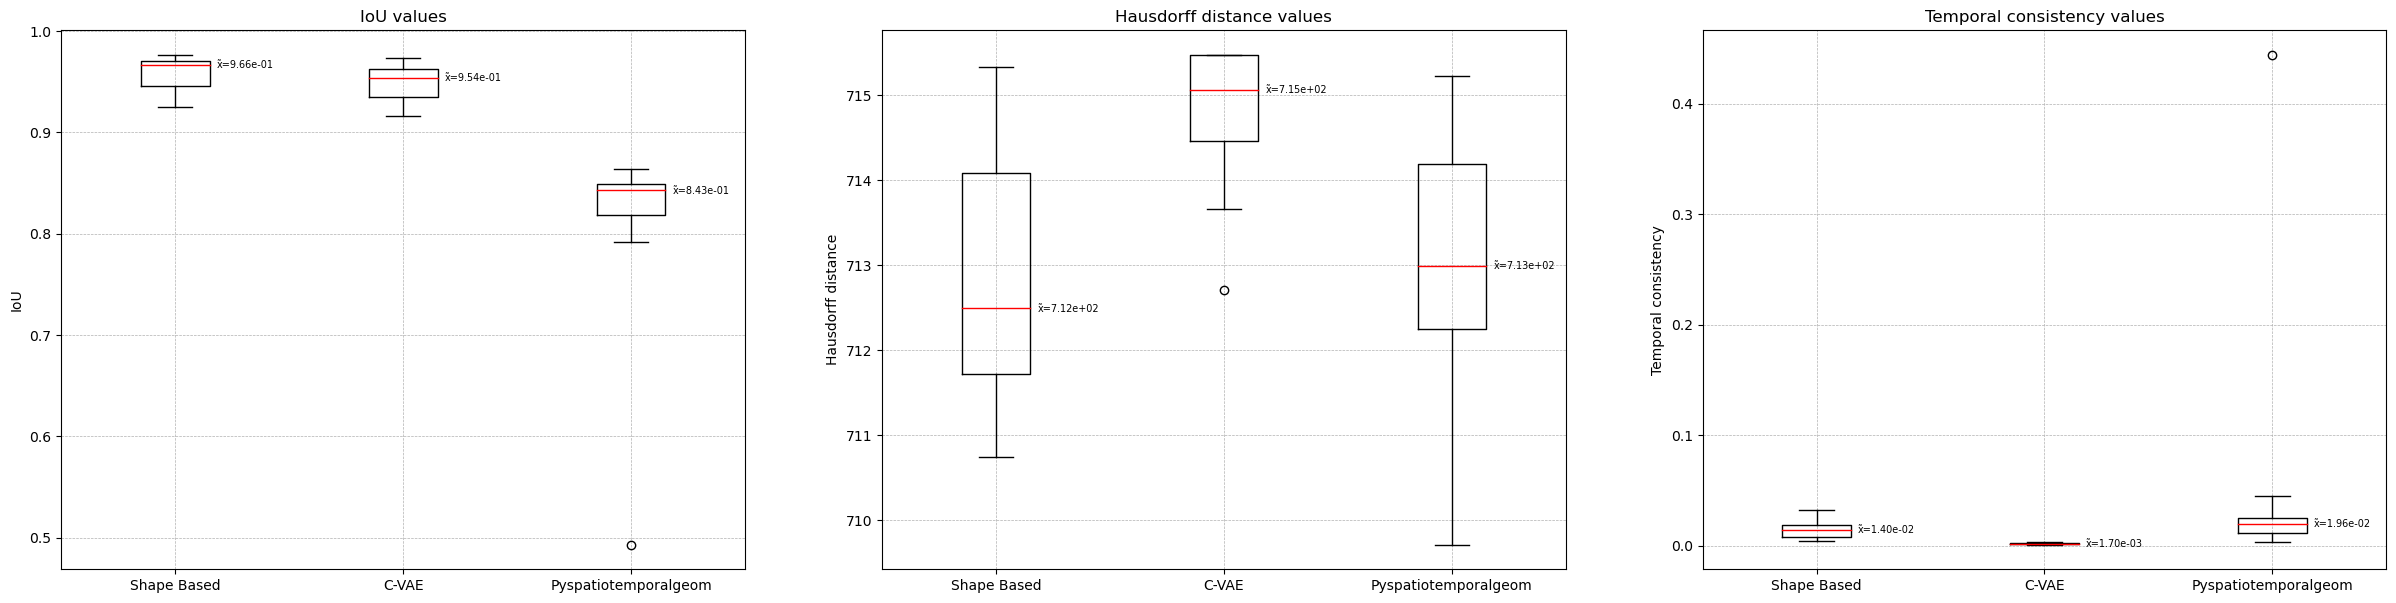

In [226]:
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# first subplot for the iou values
# join the data into a list
iou = [iou_shp_list, iou_cvae_list, iou_pstg_list]


bp_iou = axs[0].boxplot(iou, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                    medianprops={'linewidth': 1, 'color': 'red'}, patch_artist=False)
axs[0].set_title('IoU values')
axs[0].set_ylabel('IoU')
axs[0].grid(linestyle='--', linewidth=0.5)

# add median annotations
medians_iou = [med.get_ydata()[0] for med in bp_iou['medians']]
for i, median in enumerate(medians_iou):
    axs[0].annotate(f"x̃={median:.2e}", xy=(i+1, median),
                    xytext=(30,0),
                    textcoords='offset points',
                    ha='left', va='center',
                    fontsize=7)

# second subplot for the Hausdorff distance values
# join the data into a list
hd = [hd_list_shp, hd_list_cvae, hd_list_pstg]

# boxplot for the Hausdorff distance values 
bp_hd = axs[1].boxplot(hd, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                    medianprops={'linewidth': 1, 'color': 'red'}, patch_artist=False)
axs[1].set_title('Hausdorff distance values')
axs[1].set_ylabel('Hausdorff distance')
axs[1].grid(linestyle='--', linewidth=0.5)

# add median annotations
medians_iou = [med.get_ydata()[0] for med in bp_hd['medians']]
for i, median in enumerate(medians_iou):
    axs[1].annotate(f"x̃={median:.2e}", xy=(i+1, median),
                    xytext=(30,0),
                    textcoords='offset points',
                    ha='left', va='center',
                    fontsize=7)


# third subplot for the temporal consistency values
# join the data into a list
tc = [tc_shp_list, tc_cvae_list, tc_pstg_list]

# boxplot for the temporal consistency values
box_tc = axs[2].boxplot(tc, labels=['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'],
                    medianprops={'linewidth': 1, 'color': 'red'}, patch_artist=False)
axs[2].set_title('Temporal consistency values')
axs[2].set_ylabel('Temporal consistency')
axs[2].grid(linestyle='--', linewidth=0.5)

# add median annotations
medians_iou = [med.get_ydata()[0] for med in box_tc['medians']]
for i, median in enumerate(medians_iou):
    axs[2].annotate(f"x̃={median:.2e}", xy=(i+1, median),
                    xytext=(30,0),
                    textcoords='offset points',
                    ha='left', va='center',
                    fontsize=7)

#### IoU

In [291]:
print("Reading WKTs file...")
with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]

model_polys = [loads(wkt) for wkt in model_wkt]
iou_shp_list = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    intersection = g_t_polys[i].intersection(model_polys[i]).area
    union = g_t_polys[i].union(model_polys[i]).area
    # Calculate the IoU
    iou = intersection / union
    iou_shp_list.append(iou)    

# Calcula a média dos valores de IoU
iou_shp_mean = sum(iou_shp_list) / len(iou_shp_list)
print(f"CVAE interpolation: mean IoU {iou_shp_mean:.3f} \n")

Reading WKTs file...
Calculating IoU...


NameError: name 'g_t_polys' is not defined

#### Hausdorf Distance

In [ ]:
g_t_polys = [loads(wkt) for wkt in test_wkt]

model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(model_polys[i])
    hd_list_shp.append(hausdorff_dist)    

hd_mean_shp = sum(hd_list_shp) / len(hd_list_shp)
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp:.3f} \n")

## Stride Temporal Consistency

In [ ]:
print("Reading WKTs file...")
with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_list = list()
stride_rng = 10

for str in range(1, stride_rng+1):
    t_c = temporal_consistency(polygons, num_polygons, stride = str)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_list.append(t_c)